# AirBnb New York - Web Scrpaing & Data Mining 
### Matthew Gazzano - Mattgazzano@gmail.com | https://www.linkedin.com/in/matthewgazzano/

### In this project, I aim to scrape listing data from New York AirBnb listings & output the data into a structured format for later querying and visualization

In [1]:
import pandas as pd
import numpy as np
import requests, re
from bs4 import BeautifulSoup

## Extract primary listing data from search results pages
### Airbnb limits the amount of visible listings of a particular searched area to 300. Every area is displayed in 15 webpages, each consisting of 20 listing per page. In this block of code, I extract the HTML code of each listing across all searched webpages.

In [2]:
# Identify subsections of New York city that we want to search for
neighborhood_codes = [
'Manhattan--New-York--NY--'
, 'Brooklyn--Brooklyn--NY--'
, 'Queens--Queens--NY--'
, 'Staten-Island--NY--'
, 'Bronx--NY--'
, 'Midtown--New-York--NY--'
, 'Upper-East-Side--New-York--NY--'
, 'Gramercy-Park--New-York--NY--'
, 'Chelsea--New-York--NY--'
, 'SoHo--New-York--NY--'
, 'Lower-East-Side--New-York--NY--'
, 'Financial-District--New-York--NY--'
, 'Lower-Manhattan--New-York--NY--'
, 'East-Village--New-York--NY--'
, 'Little-Italy--New-York--NY--'
, 'Chinatown--New-York--NY--'
, 'Harlem--New-York--NY--']

offset_qty = 0

# Compile a list urls with paginiation. Airbnb uses the added string 'items_offset' to the url to denote
# which of the 15 pages a user is looking at. It upticks in intervals of 20 (because there are 20 listings on a page)
urls = []
for j in range(0,15):
    for i in neighborhood_codes:
        urls.append('https://www.airbnb.com/s/'+i+'United-States/homes?items_offset='+str(offset_qty*20))
    offset_qty = offset_qty + 1

# Extract the HTML code from each url
soups = []
for i in urls:
    soups.append(BeautifulSoup(requests.get(i).content,'html.parser'))

# Extract the HTML code from each listing of each url
listing_soups = []
for i in soups:
    listing_soups.append(i.find_all('div','_8ssblpx'))

## In the last loop from the above cell, the HTML code from each listing is stored inside of a 2D list, which can be visualized the following way:

[ [ 1.1_html, 1.2_html, 1.3_html, 1.4_html, 1.5_html], 1.6_html, 1.7_html, 1.8_html, 1.9_html, 1.10_html, 1.11_html, 1.12_html, 1.13_html, 1.14_html, 1.15_html, 1.16_html, 1.17_html,1.18_html,1.19_html, 1.20_html], [2.1_html ......... ] ]

## So we need to use a nested loop to extract the textual data from each listing of each search page into a dictionary. This will include the following elements:
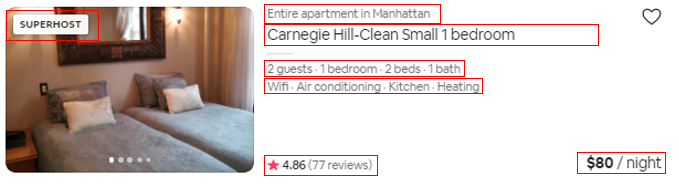

## Using the BeautifulSoup library, each textual element from the listing can be extracted using their HTML class.

## We should also note that some inputs from the listing may be omitted & as a result their HTML elements will not exist. This would cause an error in our loop. To account for this, I am using error handling to define variable values and replace non-existing HTML elements with null values in the dictionary.

In [3]:
airbnb = []
for k in range(len(listing_soups)):
    for i in range(len(listing_soups[k]))[:20]:
        try: listing_id = listing_soups[k][i].find('a').get('aria-labelledby').replace('title_','')
        except: listing_id = None
        try: listing_type = listing_soups[k][i].find('div', {'class': '_1tanv1h'}).get_text()
        except: listing_type = None
        try: name = listing_soups[k][i].find('div', {'class': '_5kaapu'}).get_text()
        except: name = None
        try: rooms = listing_soups[k][i].find('div', {'class': '_3c0zz1'}).get_text()
        except: rooms = None
        try: amenities = listing_soups[k][i].find_all("div",{"class":"_3c0zz1"})[1].get_text()
        except: amenities = None
        try: price = listing_soups[k][i].find('div', {'class': '_1gi6jw3f'}).get_text()
        except: price = None
        try: rating_reviews = listing_soups[k][i].find('div', {'class': '_h34mg6'}).get_text()
        except: rating_reviews = None
        try: superhost = True if listing_soups[k][i].find('div', {'class': '_1u0inz4'}).get_text() == 'SUPERHOST' else False
        except: superhost = False
        airbnb.append({'listing_id':listing_id,
                      'type': listing_type,
                      'name': name,
                      'rooms':rooms,
                      'amenities':amenities,
                      'price':price,
                      'rating_reviews':rating_reviews,
                      'superhost':superhost})

airbnb

[{'listing_id': '3585452',
  'type': 'Entire rental unit in Manhattan',
  'name': 'A Beautiful Brownstone Apartment',
  'rooms': '4 guests · Studio · 3 beds · 1 bath',
  'amenities': 'Wifi · Air conditioning · Kitchen · Heating',
  'price': '$91\xa0/ night',
  'rating_reviews': '4.76\xa0(339 reviews)$91\xa0/ night$91 per night',
  'superhost': True},
 {'listing_id': '45767160',
  'type': 'Entire rental unit in Chinatown',
  'name': 'Cozy apartment in the heart of Downtown Manhattan',
  'rooms': '3 guests · 2 bedrooms · 2 beds · 1 bath',
  'amenities': 'Wifi · Kitchen · Heating',
  'price': '$75\xa0/ night',
  'rating_reviews': '$75\xa0/ night$75 per night',
  'superhost': True},
 {'listing_id': '46756139',
  'type': 'Hotel room in South Street Seaport',
  'name': 'Perfect Extended Stay 21+ Days Hotel Room',
  'rooms': '2 guests · 1 bedroom · 1 bed · 1 private bath',
  'amenities': 'Wifi · Air conditioning · Heating',
  'price': '$84\xa0/ night',
  'rating_reviews': '$84\xa0/ night$84 p

## Now we will need to write the dictionary into a Pandas dataframe. Because of how the data was scraped, duplicate listings will exist- for example, listing xxx could have appeared on the webpage for Soho and Lower Manhattan since these subsections of NYC are close in proximity. So I will dedupe the dataframe by listing_id.
## While deduping the list, I found that the value of the 'type' column can vary depending on the webpage it was sourced from, with the default location being 'New York'
### For Example, listing_id 'xxx' may show up on the listing as 'Private Room in Upper West Side' on one search results page, and 'Private Room in New York' on another search results page.
### To account for this, I will sort the dataframe by a new column 'dedeupe_key', which assigns listings containing 'New York' the highest value. Then I sort the dataframe by this column in ascending order, dedupe the dataframe based on listing_id, and keep the first listing_id that appears.

In [4]:
#convert dictionary Into a Pandas dataframe
df_airbnb_ny = pd.DataFrame.from_dict(airbnb)

#Drop Rows with Blank Listing Data
df_airbnb_ny = df_airbnb_ny.dropna(axis=0, subset=['listing_id'])

# Remove listings that that have 'room types'
#when this termonology is in the 'rooms' variable,it relates to a hotel / motel, which will skew our data
df_airbnb_ny[~df_airbnb_ny.rooms.str.contains('room types')]                                              

# We only want to keep the entry labled with its subsection
# Sort the dataframe by type, moving 'New York' to the bottom, then dedupde the dataframe by listing ID
df_airbnb_ny['dedupe_key'] = np.where(df_airbnb_ny['type'].str.contains('New York'), 2, 1)
df_airbnb_ny.sort_values(by=['dedupe_key'])
df_airbnb_ny = df_airbnb_ny.drop_duplicates(subset=['listing_id'],keep='first')

#Set the listing_id column as the index of the dataframe
df_airbnb_ny = df_airbnb_ny.set_index('listing_id')

#Drop dedupe_key and display output
df_airbnb_ny = df_airbnb_ny.drop(columns = 'dedupe_key')
df_airbnb_ny.head()

,type,name,rooms,amenities,price,rating_reviews,superhost
listing_id,,,,,,,
3585452,Entire rental unit in Manhattan,A Beautiful Brownstone Apartment,4 guests · Studio · 3 beds · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$91 / night,4.76 (339 reviews)$91 / night$91 per night,True
45767160,Entire rental unit in Chinatown,Cozy apartment in the heart of Downtown Manhattan,3 guests · 2 bedrooms · 2 beds · 1 bath,Wifi · Kitchen · Heating,$75 / night,$75 / night$75 per night,True
46756139,Hotel room in South Street Seaport,Perfect Extended Stay 21+ Days Hotel Room,2 guests · 1 bedroom · 1 bed · 1 private bath,Wifi · Air conditioning · Heating,$84 / night,$84 / night$84 per night,True
49705162,Entire rental unit in Soho,Modern and charming 1BR in the heart of SoHo,4 guests · 1 bedroom · 2 beds · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$140 / night,$140 / night$140 per night,False
47996191,Entire rental unit in Manhattan,Furnished Studio in Little Italy,2 guests · Studio · 1 bed · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$110 / night,$110 / night$110 per night,False


In [5]:
# # Write the dataframe to a csv file
# df_airbnb_ny.to_csv('df_airbnb_ny.csv')

# Extracting location data
## To get the latitude and longitude of each listing (for later data visualization through heat mapping), we will need to use a different method via the requests library and re (regular expression) module. These data points can be extracted using a regex function from a script tag found on the individual listing page.
## While running this loop, I found that some listings were temperamentally returning null latitude and longitude values, with results varying during each loop.
### To account for this, I reinstantiate the request function & reassign the latitude and longitude variables inside of a while loop until the value is not null.
### This is a time intensive process, so i am purposely running this block after the dataframe has been deduped to limit the number of iterations, and print out the enumerated results to show progress as it writes to a dictionary. I am also showing when the loop had to reinstantiate the request due to a null value, denoted by '(retry attempt)'
### My machine outputs this at a rate of ≈ .71 seconds per listing.

In [6]:
#Print and write to dictionary
airbnb_locations = []
listing_ids = df_airbnb_ny.index.to_list()
        
for count, i in enumerate(listing_ids, start=1):
    r = requests.get('https://www.airbnb.com/rooms/'+str(i))
    latitude = re.compile(r'"lat":([-0-9.]+),').findall(r.text)
    longitude = re.compile(r'"lng":([-0-9.]+),').findall(r.text)
    if latitude == [] or longitude == []:
        while latitude == [] or longitude == []:
            r = requests.get('https://www.airbnb.com/rooms/'+str(i))
            latitude = re.compile(r'"lat":([-0-9.]+),').findall(r.text)
            longitude = re.compile(r'"lng":([-0-9.]+),').findall(r.text)
            if latitude == [] or longitude ==[]:
                continue
            else:
                 airbnb_locations.append({
                'listing_id':i
                ,'latitude':latitude
                ,'longitude':longitude})
            print(count,'of '+str(len(listing_ids))+':',i,latitude,longitude)
    else:
        airbnb_locations.append({
        'listing_id':i
        ,'latitude':latitude
        ,'longitude':longitude})
        print(count,'of '+str(len(listing_ids))+':',i,latitude,longitude,' (retry attempt)')
             
airbnb_locations

1 of 2786: 3585452 ['40.80872'] ['-73.94124']
2 of 2786: 45767160 ['40.71394'] ['-73.99123']  (retry attempt)
3 of 2786: 46756139 ['40.70616'] ['-74.00379']
4 of 2786: 49705162 ['40.72371'] ['-74.0019']  (retry attempt)
5 of 2786: 47996191 ['40.72025'] ['-73.9938']
6 of 2786: 12317903 ['40.75307'] ['-73.96691']
7 of 2786: 45547297 ['40.76526'] ['-73.98867']
8 of 2786: 48131207 ['40.74328'] ['-73.98076']
9 of 2786: 25802121 ['40.76612'] ['-73.98273']  (retry attempt)
10 of 2786: 48253767 ['40.77467'] ['-73.91581']  (retry attempt)
11 of 2786: 42746488 ['40.73437'] ['-73.98728']
12 of 2786: 49362741 ['40.7976'] ['-73.96189']
13 of 2786: 45772997 ['40.76238'] ['-73.98917']
14 of 2786: 44337778 ['40.72861'] ['-73.98348']  (retry attempt)
15 of 2786: 50913661 ['40.74057'] ['-73.97755']
16 of 2786: 50197742 ['40.766'] ['-73.99453']  (retry attempt)
17 of 2786: 49409612 ['40.77796'] ['-73.96073']
18 of 2786: 49100116 ['40.75717'] ['-73.98347']  (retry attempt)
19 of 2786: 45988921 ['40.76454'

150 of 2786: 45470310 ['40.73888'] ['-73.99919']
151 of 2786: 16405036 ['40.74324'] ['-73.99729']  (retry attempt)
152 of 2786: 17218433 ['40.74042'] ['-73.99849']  (retry attempt)
153 of 2786: 35384734 ['40.73924'] ['-74.00366']
154 of 2786: 41454887 ['40.72678'] ['-74.00176']  (retry attempt)
155 of 2786: 49793548 ['40.73131'] ['-74.00445']
156 of 2786: 46077274 ['40.7327'] ['-74.0055']  (retry attempt)
157 of 2786: 14316284 ['40.72939'] ['-74.00203']
158 of 2786: 45598105 ['40.7202'] ['-73.99385']  (retry attempt)
159 of 2786: 43315235 ['40.71962'] ['-73.9939']  (retry attempt)
160 of 2786: 15218342 ['40.7265'] ['-74.0032']  (retry attempt)
161 of 2786: 43315428 ['40.71863'] ['-73.99562']  (retry attempt)
162 of 2786: 17653243 ['40.719'] ['-73.9977']
163 of 2786: 2478825 ['40.7235'] ['-74.00243']
164 of 2786: 47448127 ['40.732'] ['-74.0058']
165 of 2786: 10726217 ['40.72245'] ['-73.99647']
166 of 2786: 47162719 ['40.71986'] ['-73.99415']
167 of 2786: 50074337 ['40.72887'] ['-74.0027

295 of 2786: 2889387 ['40.64367'] ['-74.0794']  (retry attempt)
296 of 2786: 48758785 ['40.58541'] ['-74.07033']
297 of 2786: 27967621 ['40.63607'] ['-74.09631']  (retry attempt)
298 of 2786: 17554298 ['40.53894'] ['-74.16983']  (retry attempt)
299 of 2786: 46436269 ['40.64142'] ['-74.08346']
300 of 2786: 46991303 ['40.63164'] ['-74.13201']  (retry attempt)
301 of 2786: 19930489 ['40.6059'] ['-74.088']  (retry attempt)
302 of 2786: 8664611 ['40.62872'] ['-74.12154']
303 of 2786: 4974843 ['40.63268'] ['-74.12607']  (retry attempt)
304 of 2786: 10413576 ['40.64365'] ['-74.09113']
305 of 2786: 23219361 ['40.59273'] ['-74.07552']
306 of 2786: 16097822 ['40.59511'] ['-74.08757']
307 of 2786: 14389357 ['40.60944'] ['-74.0869']  (retry attempt)
308 of 2786: 48280019 ['40.6335'] ['-74.11639']
309 of 2786: 29517676 ['40.62692'] ['-74.11346']  (retry attempt)
310 of 2786: 27203413 ['40.6385'] ['-74.0923']
311 of 2786: 14892623 ['40.59273'] ['-74.08831']
312 of 2786: 49591825 ['40.62837'] ['-74.0

440 of 2786: 13114203 ['40.719'] ['-73.9977']  (retry attempt)
441 of 2786: 45752267 ['40.71848'] ['-73.99585']  (retry attempt)
442 of 2786: 5525510 ['40.71915'] ['-73.99869']  (retry attempt)
443 of 2786: 44748353 ['40.72009'] ['-73.99462']  (retry attempt)
444 of 2786: 40406049 ['40.71999'] ['-73.99585']
445 of 2786: 22464295 ['40.7218'] ['-73.9923']
446 of 2786: 50432864 ['40.71606'] ['-74.0002']  (retry attempt)
447 of 2786: 48942774 ['40.71375'] ['-73.99521']
448 of 2786: 848071 ['40.71738'] ['-73.99231']  (retry attempt)
449 of 2786: 51011444 ['40.71653'] ['-73.99726']  (retry attempt)
450 of 2786: 9477489 ['40.7117'] ['-73.9959']  (retry attempt)
451 of 2786: 13075158 ['40.71328'] ['-73.996']
452 of 2786: 48105141 ['40.71351'] ['-73.99706']  (retry attempt)
453 of 2786: 46526234 ['40.71378'] ['-73.98988']  (retry attempt)
454 of 2786: 47772275 ['40.8263'] ['-73.97635']
455 of 2786: 9167889 ['40.80864'] ['-73.9428']
456 of 2786: 12110663 ['40.80602'] ['-73.95367']  (retry attemp

584 of 2786: 41402463 ['40.73292'] ['-73.98483']
585 of 2786: 747159 ['40.73172'] ['-73.98452']
586 of 2786: 27598707 ['40.740303'] ['-73.985985']
587 of 2786: 50135045 ['40.75093'] ['-74.00241']  (retry attempt)
588 of 2786: 18386307 ['40.7496'] ['-73.9964']
589 of 2786: 41456919 ['40.76685'] ['-73.98983']  (retry attempt)
590 of 2786: 8210423 ['40.74374'] ['-74.00086']
591 of 2786: 40882059 ['40.74935'] ['-73.99722']  (retry attempt)
592 of 2786: 47567710 ['40.75385'] ['-74.00072']  (retry attempt)
593 of 2786: 33734483 ['40.7327'] ['-74.0055']  (retry attempt)
594 of 2786: 222304 ['40.7401'] ['-74.00019']  (retry attempt)
595 of 2786: 42018495 ['40.736'] ['-73.99719']  (retry attempt)
596 of 2786: 13108573 ['40.75095'] ['-73.99565']  (retry attempt)
597 of 2786: 37140989 ['40.72028'] ['-73.99893']  (retry attempt)
598 of 2786: 48827696 ['40.72485'] ['-74.00327']
599 of 2786: 43267312 ['40.72032'] ['-73.99548']
600 of 2786: 35490967 ['40.7327'] ['-74.0055']
601 of 2786: 35385249 ['40

726 of 2786: 19929723 ['40.6059'] ['-74.088']
727 of 2786: 27852410 ['40.597'] ['-74.0833']
728 of 2786: 21981845 ['40.62945'] ['-74.12391']  (retry attempt)
729 of 2786: 16974611 ['40.62814'] ['-74.08666']  (retry attempt)
730 of 2786: 24476209 ['40.59807'] ['-74.08416']  (retry attempt)
731 of 2786: 51499702 ['40.580128191481094'] ['-74.10031740663568']  (retry attempt)
732 of 2786: 24412681 ['40.63241'] ['-74.13834']
733 of 2786: 31957975 ['40.61572'] ['-74.0671']
734 of 2786: 23839013 ['40.61887'] ['-74.09107']
735 of 2786: 16289973 ['40.63189'] ['-74.11308']  (retry attempt)
736 of 2786: 38815987 ['40.5479'] ['-74.21088']  (retry attempt)
737 of 2786: 42643177 ['40.57722'] ['-74.0832']
738 of 2786: 3465651 ['40.54153'] ['-74.16442']  (retry attempt)
739 of 2786: 8934409 ['40.63127'] ['-74.08672']  (retry attempt)
740 of 2786: 51444781 ['40.64393'] ['-74.08609']
741 of 2786: 31717883 ['40.60174'] ['-74.08298']
742 of 2786: 20772204 ['40.89748'] ['-73.85497']
743 of 2786: 11371535 [

870 of 2786: 45944408 ['40.82102'] ['-73.94562']  (retry attempt)
871 of 2786: 18303895 ['40.80384'] ['-73.94965']  (retry attempt)
872 of 2786: 5144689 ['40.8058'] ['-73.9423']  (retry attempt)
873 of 2786: 1438870 ['40.82397'] ['-73.94418']
874 of 2786: 11873498 ['40.8234'] ['-73.95293']  (retry attempt)
875 of 2786: 46794371 ['40.83581'] ['-73.94717']  (retry attempt)
876 of 2786: 1063020 ['40.79346'] ['-73.94374']  (retry attempt)
877 of 2786: 21175160 ['40.81969'] ['-73.94667']
878 of 2786: 5390882 ['40.80254'] ['-73.94356']  (retry attempt)
879 of 2786: 4426780 ['40.81579'] ['-73.93754']
880 of 2786: 26334022 ['40.8141'] ['-73.9435']
881 of 2786: 10253769 ['40.82575'] ['-73.93665']  (retry attempt)
882 of 2786: 49346369 ['40.76442'] ['-73.99451']
883 of 2786: 43819542 ['40.68926'] ['-73.94995']
884 of 2786: 19329404 ['40.67809'] ['-73.99875']  (retry attempt)
885 of 2786: 38183143 ['40.68017'] ['-74.01165']  (retry attempt)
886 of 2786: 16157731 ['40.68946'] ['-73.99171']  (retry

1012 of 2786: 28833807 ['40.73011'] ['-73.99855']
1013 of 2786: 14690331 ['40.73506'] ['-74.00788']
1014 of 2786: 33560460 ['40.72543'] ['-74.00403']
1015 of 2786: 46942439 ['40.72794'] ['-73.99667']  (retry attempt)
1016 of 2786: 8268849 ['40.72214'] ['-74.00443']  (retry attempt)
1017 of 2786: 45350904 ['40.72005'] ['-74.00328']
1018 of 2786: 47098575 ['40.71891'] ['-73.99589']  (retry attempt)
1019 of 2786: 48282693 ['40.71797'] ['-73.99412']
1020 of 2786: 50997233 ['40.72113'] ['-73.99319']
1021 of 2786: 47357819 ['40.71993'] ['-73.98721']  (retry attempt)
1022 of 2786: 22465657 ['40.7218'] ['-73.9923']  (retry attempt)
1023 of 2786: 47885843 ['40.70535'] ['-74.01094']
1024 of 2786: 37240184 ['40.70501'] ['-74.0077']  (retry attempt)
1025 of 2786: 46280898 ['40.70633'] ['-74.01631']  (retry attempt)
1026 of 2786: 47042470 ['40.7066'] ['-74.0114']
1027 of 2786: 46544275 ['40.70463'] ['-74.00544']  (retry attempt)
1028 of 2786: 38958466 ['40.71014'] ['-74.01454']  (retry attempt)
102

1153 of 2786: 48451389 ['40.76085'] ['-73.99287']  (retry attempt)
1154 of 2786: 12112190 ['40.7641'] ['-73.9937']  (retry attempt)
1155 of 2786: 30125704 ['40.7493'] ['-73.9764']
1156 of 2786: 50900304 ['40.76324'] ['-73.99297']  (retry attempt)
1157 of 2786: 48829183 ['40.7564'] ['-73.99477']  (retry attempt)
1158 of 2786: 50459600 ['40.756'] ['-73.99339']  (retry attempt)
1159 of 2786: 42125107 ['40.76224'] ['-73.98886']
1160 of 2786: 44353017 ['40.77189'] ['-73.95151']  (retry attempt)
1161 of 2786: 37750997 ['40.78622'] ['-73.96936']  (retry attempt)
1162 of 2786: 50743172 ['40.77008'] ['-73.95863']
1163 of 2786: 46729395 ['40.78191'] ['-73.95386']  (retry attempt)
1164 of 2786: 45097782 ['40.76925'] ['-73.95773']  (retry attempt)
1165 of 2786: 6990 ['40.78778'] ['-73.94759']  (retry attempt)
1166 of 2786: 16346574 ['40.76147'] ['-73.95726']
1167 of 2786: 227495 ['40.78764'] ['-73.97274']  (retry attempt)
1168 of 2786: 43701555 ['40.7767'] ['-73.94631']
1169 of 2786: 49529057 ['40

1298 of 2786: 47834082 ['40.70709'] ['-73.7176']
1299 of 2786: 39313969 ['40.69983'] ['-73.75368']
1300 of 2786: 49320836 ['40.70649'] ['-73.74763']
1301 of 2786: 8623370 ['40.71869'] ['-73.75395']  (retry attempt)
1302 of 2786: 40529147 ['40.69154'] ['-73.7479']  (retry attempt)
1303 of 2786: 39952819 ['40.69276'] ['-73.73362']  (retry attempt)
1304 of 2786: 45868989 ['40.68465'] ['-73.74687']  (retry attempt)
1305 of 2786: 22985419 ['40.72128'] ['-73.75642']  (retry attempt)
1306 of 2786: 39482193 ['40.67808'] ['-73.73017']  (retry attempt)
1307 of 2786: 36360072 ['40.68835'] ['-73.75634']  (retry attempt)
1308 of 2786: 42336485 ['40.728'] ['-73.74948']  (retry attempt)
1309 of 2786: 14606197 ['40.6857'] ['-73.7188']  (retry attempt)
1310 of 2786: 37591884 ['40.69289'] ['-73.73283']  (retry attempt)
1311 of 2786: 49145365 ['40.685'] ['-73.76792']  (retry attempt)
1312 of 2786: 17418006 ['40.69148'] ['-73.74738']  (retry attempt)
1313 of 2786: 20230482 ['40.69158'] ['-73.75647']  (ret

1439 of 2786: 47593392 ['40.71499'] ['-73.99137']  (retry attempt)
1440 of 2786: 40030014 ['40.82456'] ['-73.94104']  (retry attempt)
1441 of 2786: 41900007 ['40.80746'] ['-73.94989']  (retry attempt)
1442 of 2786: 43103808 ['40.80709'] ['-73.95123']  (retry attempt)
1443 of 2786: 15067291 ['40.80981'] ['-73.94492']
1444 of 2786: 34181328 ['40.805'] ['-73.94299']  (retry attempt)
1445 of 2786: 30105137 ['40.80255'] ['-73.94731']  (retry attempt)
1446 of 2786: 44360566 ['40.81667'] ['-73.94253']
1447 of 2786: 31467888 ['40.79832'] ['-73.9602']
1448 of 2786: 476983 ['40.8239'] ['-73.94242']
1449 of 2786: 4081800 ['40.80988'] ['-73.94403']  (retry attempt)
1450 of 2786: 46179119 ['40.80916'] ['-73.95148']  (retry attempt)
1451 of 2786: 45721454 ['40.8306'] ['-73.947']
1452 of 2786: 1619695 ['40.82193'] ['-73.94955']  (retry attempt)
1453 of 2786: 18430588 ['40.82366'] ['-73.94514']
1454 of 2786: 39446832 ['40.81805'] ['-73.9404']  (retry attempt)
1455 of 2786: 46083002 ['40.79591'] ['-73.

1579 of 2786: 3339273 ['40.75007'] ['-73.99723']
1580 of 2786: 49212356 ['40.73886'] ['-73.99978']
1581 of 2786: 50510257 ['40.7447'] ['-74.00467']
1582 of 2786: 51188830 ['40.75544'] ['-73.99395']
1583 of 2786: 45100309 ['40.74683'] ['-74.00019']  (retry attempt)
1584 of 2786: 49387570 ['40.74948'] ['-73.99811']
1585 of 2786: 16601801 ['40.73217'] ['-74.00479']
1586 of 2786: 33769956 ['40.72358'] ['-73.99524']  (retry attempt)
1587 of 2786: 45505393 ['40.72064'] ['-74.00935']
1588 of 2786: 48980478 ['40.72421'] ['-73.99382']  (retry attempt)
1589 of 2786: 42327227 ['40.71318'] ['-73.98902']
1590 of 2786: 3832863 ['40.72777'] ['-74.00427']  (retry attempt)
1591 of 2786: 19280591 ['40.73328'] ['-74.00179']
1592 of 2786: 34071699 ['40.7244'] ['-74.007935']
1593 of 2786: 71248 ['40.7159'] ['-73.99156']  (retry attempt)
1594 of 2786: 50997070 ['40.72228'] ['-73.99157']  (retry attempt)
1595 of 2786: 17465159 ['40.72371'] ['-73.98092']
1596 of 2786: 2339096 ['40.71525'] ['-73.98929']
1597 o

1722 of 2786: 45359270 ['40.77423'] ['-73.94802']  (retry attempt)
1723 of 2786: 47729102 ['40.77005'] ['-73.95648']  (retry attempt)
1724 of 2786: 16347965 ['40.7671'] ['-73.97136']
1725 of 2786: 35231370 ['40.7614'] ['-73.96526']
1726 of 2786: 49132815 ['40.78186'] ['-73.95203']  (retry attempt)
1727 of 2786: 45689225 ['40.77097'] ['-73.95749']  (retry attempt)
1728 of 2786: 12833187 ['40.76334'] ['-73.96301']  (retry attempt)
1729 of 2786: 45581450 ['40.76172'] ['-73.96228']
1730 of 2786: 49617730 ['40.78648'] ['-73.95049']
1731 of 2786: 21161561 ['40.77218'] ['-73.95991']
1732 of 2786: 13912712 ['40.7703'] ['-73.9572']
1733 of 2786: 49860325 ['40.77706'] ['-73.95418']  (retry attempt)
1734 of 2786: 43088328 ['40.7321'] ['-73.9836']
1735 of 2786: 49946715 ['40.7464'] ['-73.98701']  (retry attempt)
1736 of 2786: 44744365 ['40.72971'] ['-73.98694']
1737 of 2786: 48867046 ['40.7338'] ['-73.98532']  (retry attempt)
1738 of 2786: 33611809 ['40.73925'] ['-73.97989']  (retry attempt)
1739 

1862 of 2786: 51037520 ['40.63259'] ['-74.1058']  (retry attempt)
1863 of 2786: 39227915 ['40.62468'] ['-74.16731']
1864 of 2786: 43197566 ['40.64557'] ['-74.08443']
1865 of 2786: 8275676 ['40.54615'] ['-74.14654']
1866 of 2786: 5291956 ['40.66246'] ['-73.9933']  (retry attempt)
1867 of 2786: 48170482 ['40.57686'] ['-74.23342']
1868 of 2786: 47355990 ['40.63133'] ['-74.09559']
1869 of 2786: 47286267 ['40.63133'] ['-74.0912']  (retry attempt)
1870 of 2786: 17735156 ['40.63125'] ['-74.12226']  (retry attempt)
1871 of 2786: 35932623 ['40.6583'] ['-74.12674']  (retry attempt)
1872 of 2786: 44415969 ['40.63564'] ['-74.08153']  (retry attempt)
1873 of 2786: 5354796 ['40.85477'] ['-73.91597']  (retry attempt)
1874 of 2786: 169306 ['40.85981'] ['-73.9063']  (retry attempt)
1875 of 2786: 2848235 ['40.85568'] ['-73.9137']  (retry attempt)
1876 of 2786: 41880997 ['40.84106'] ['-73.92465']  (retry attempt)
1877 of 2786: 45235897 ['40.87683'] ['-73.84297']  (retry attempt)
1878 of 2786: 49613832 ['

2002 of 2786: 51546425 ['40.6972064538218'] ['-73.99454965922787']  (retry attempt)
2003 of 2786: 2913960 ['40.68452'] ['-73.99093']
2004 of 2786: 48110431 ['40.68106'] ['-73.99101']  (retry attempt)
2005 of 2786: 49702711 ['40.68299'] ['-73.98701']  (retry attempt)
2006 of 2786: 44810048 ['40.69647'] ['-73.99663']  (retry attempt)
2007 of 2786: 23035944 ['40.69067'] ['-73.9988']  (retry attempt)
2008 of 2786: 32913140 ['40.67974'] ['-74.00985']
2009 of 2786: 23715988 ['40.68567'] ['-73.98934']  (retry attempt)
2010 of 2786: 34014834 ['40.70129'] ['-73.72074']
2011 of 2786: 43421098 ['40.68676'] ['-73.71924']  (retry attempt)
2012 of 2786: 47710373 ['40.69572'] ['-73.75134']
2013 of 2786: 50682023 ['40.6805'] ['-73.71042']  (retry attempt)
2014 of 2786: 16578780 ['40.6931'] ['-73.76949']  (retry attempt)
2015 of 2786: 16749885 ['40.6787'] ['-73.71914']  (retry attempt)
2016 of 2786: 43747226 ['40.6864'] ['-73.7356']
2017 of 2786: 44241276 ['40.7105'] ['-73.76476']
2018 of 2786: 1487415

2142 of 2786: 30068059 ['40.71108'] ['-73.99817']
2143 of 2786: 37054496 ['40.7359'] ['-74.00092']
2144 of 2786: 34495013 ['40.72892'] ['-73.98556']
2145 of 2786: 28180748 ['40.72762'] ['-73.98601']  (retry attempt)
2146 of 2786: 45691383 ['40.72034'] ['-73.99387']  (retry attempt)
2147 of 2786: 45070596 ['40.72441'] ['-73.98795']
2148 of 2786: 48052172 ['40.72514'] ['-73.98421']
2149 of 2786: 50752392 ['40.72067'] ['-73.99626']
2150 of 2786: 20614820 ['40.71632'] ['-73.99273']
2151 of 2786: 50485095 ['40.72365'] ['-73.98861']
2152 of 2786: 5040653 ['40.71785'] ['-73.99019']  (retry attempt)
2153 of 2786: 51596553 ['40.722867956521554'] ['-73.99225533559868']  (retry attempt)
2154 of 2786: 42279171 ['40.716103', '40.716103'] ['-73.995178', '-73.995178']
2155 of 2786: 11295457 ['40.80264'] ['-73.94406']  (retry attempt)
2156 of 2786: 3512428 ['40.82823'] ['-73.95054']
2157 of 2786: 11372330 ['40.8141'] ['-73.9437']  (retry attempt)
2158 of 2786: 10748040 ['40.83071'] ['-73.94557']  (ret

2281 of 2786: 37140722 ['40.7198'] ['-74']  (retry attempt)
2282 of 2786: 43691688 ['40.7257'] ['-74.0032']  (retry attempt)
2283 of 2786: 10941762 ['40.72271'] ['-73.99262']
2284 of 2786: 3687172 ['40.72704'] ['-74.00085']
2285 of 2786: 15966974 ['40.72658'] ['-74.00248']  (retry attempt)
2286 of 2786: 13495558 ['40.72805'] ['-74.00266']  (retry attempt)
2287 of 2786: 1656539 ['40.72986'] ['-74.00299']  (retry attempt)
2288 of 2786: 37122502 ['40.7238'] ['-73.99038']  (retry attempt)
2289 of 2786: 9806606 ['40.72202'] ['-73.98256']
2290 of 2786: 50748961 ['40.72307'] ['-73.99226']  (retry attempt)
2291 of 2786: 49631195 ['40.72115'] ['-73.984']  (retry attempt)
2292 of 2786: 51493475 ['40.712040832539216'] ['-73.96719690437105']
2293 of 2786: 47451563 ['40.71968'] ['-73.98367']
2294 of 2786: 16504546 ['40.71354'] ['-74.00537']
2295 of 2786: 45481829 ['40.71508'] ['-74.00683']
2296 of 2786: 51017632 ['40.7055'] ['-74.0095']  (retry attempt)
2297 of 2786: 46753916 ['40.70626'] ['-74.005

2421 of 2786: 37722378 ['40.73122'] ['-73.98303']
2422 of 2786: 34929338 ['40.72482'] ['-73.98318']
2423 of 2786: 41586173 ['40.73868'] ['-73.97963']  (retry attempt)
2424 of 2786: 49593677 ['40.72753'] ['-73.98818']
2425 of 2786: 30394133 ['40.7457'] ['-73.9799']  (retry attempt)
2426 of 2786: 51052642 ['40.7465'] ['-73.98846']  (retry attempt)
2427 of 2786: 4475234 ['40.72954'] ['-73.98247']  (retry attempt)
2428 of 2786: 19275305 ['40.7409'] ['-73.98988']
2429 of 2786: 28130502 ['40.73377'] ['-73.99252']  (retry attempt)
2430 of 2786: 43197778 ['40.75683'] ['-73.99317']
2431 of 2786: 45530783 ['40.75162'] ['-73.99347']  (retry attempt)
2432 of 2786: 48680807 ['40.74169'] ['-74.00262']
2433 of 2786: 29327591 ['40.7377'] ['-73.99782']
2434 of 2786: 51570734 ['40.74666414606278'] ['-74.00182540523795']  (retry attempt)
2435 of 2786: 35220744 ['40.75883'] ['-73.99547']  (retry attempt)
2436 of 2786: 43069280 ['40.75139'] ['-74.00395']
2437 of 2786: 41663709 ['40.74159'] ['-74.00029']
24

2560 of 2786: 46255120 ['40.72811'] ['-73.97987']  (retry attempt)
2561 of 2786: 48030418 ['40.74383'] ['-73.97973']
2562 of 2786: 49128388 ['40.74371'] ['-73.98639']
2563 of 2786: 13950233 ['40.74044'] ['-73.98101']
2564 of 2786: 46377270 ['40.73715'] ['-73.98028']
2565 of 2786: 13417080 ['40.7355'] ['-73.98721']  (retry attempt)
2566 of 2786: 24424840 ['40.74513'] ['-73.97754']
2567 of 2786: 28811035 ['40.73271'] ['-73.99617']  (retry attempt)
2568 of 2786: 37404277 ['40.72683'] ['-73.98676']  (retry attempt)
2569 of 2786: 49054018 ['40.7369'] ['-73.9927']  (retry attempt)
2570 of 2786: 15159731 ['40.73994'] ['-73.97945']  (retry attempt)
2571 of 2786: 51003096 ['40.74697'] ['-73.97504']
2572 of 2786: 45531011 ['40.73953'] ['-73.9828']
2573 of 2786: 49054028 ['40.7369'] ['-73.9927']  (retry attempt)
2574 of 2786: 7837952 ['40.74153'] ['-73.98522']  (retry attempt)
2575 of 2786: 50792146 ['40.7407'] ['-73.99938']
2576 of 2786: 50895317 ['40.75561'] ['-73.99511']  (retry attempt)
2577 

2702 of 2786: 10732197 ['40.7627'] ['-73.9491']
2703 of 2786: 32501003 ['40.77021'] ['-73.95474']
2704 of 2786: 50740601 ['40.76836'] ['-73.95273']
2705 of 2786: 50698071 ['40.76935874815763'] ['-73.9605402259594']
2706 of 2786: 45530652 ['40.77271'] ['-73.94872']
2707 of 2786: 17631431 ['40.77245'] ['-73.94629']
2708 of 2786: 45578986 ['40.78225'] ['-73.95408']
2709 of 2786: 49613686 ['40.76209'] ['-73.96078']
2710 of 2786: 47486539 ['40.76944'] ['-73.95693']  (retry attempt)
2711 of 2786: 32933643 ['40.78258'] ['-73.94507']
2712 of 2786: 4668252 ['40.77518'] ['-73.95339']
2713 of 2786: 46826044 ['40.73572'] ['-73.99689']
2714 of 2786: 39507510 ['40.73034'] ['-73.98399']  (retry attempt)
2715 of 2786: 652466 ['40.74341'] ['-73.98271']
2716 of 2786: 40060949 ['40.7419'] ['-73.9893']  (retry attempt)
2717 of 2786: 8536270 ['40.74572'] ['-73.97531']
2718 of 2786: 11840404 ['40.74045'] ['-73.98']
2719 of 2786: 50133133 ['40.72858'] ['-73.9809']  (retry attempt)
2720 of 2786: 25672109 ['40

[{'listing_id': '3585452',
  'latitude': ['40.80872'],
  'longitude': ['-73.94124']},
 {'listing_id': '45767160',
  'latitude': ['40.71394'],
  'longitude': ['-73.99123']},
 {'listing_id': '46756139',
  'latitude': ['40.70616'],
  'longitude': ['-74.00379']},
 {'listing_id': '49705162',
  'latitude': ['40.72371'],
  'longitude': ['-74.0019']},
 {'listing_id': '47996191',
  'latitude': ['40.72025'],
  'longitude': ['-73.9938']},
 {'listing_id': '12317903',
  'latitude': ['40.75307'],
  'longitude': ['-73.96691']},
 {'listing_id': '45547297',
  'latitude': ['40.76526'],
  'longitude': ['-73.98867']},
 {'listing_id': '48131207',
  'latitude': ['40.74328'],
  'longitude': ['-73.98076']},
 {'listing_id': '25802121',
  'latitude': ['40.76612'],
  'longitude': ['-73.98273']},
 {'listing_id': '48253767',
  'latitude': ['40.77467'],
  'longitude': ['-73.91581']},
 {'listing_id': '42746488',
  'latitude': ['40.73437'],
  'longitude': ['-73.98728']},
 {'listing_id': '49362741',
  'latitude': ['40

## Now we need to write the airbnb_location dictionary to a pandas dataframe, and join it to the df_airbnb_ny dataframe.

In [7]:
#Write to a dataframe
df_airbnb_locations = pd.DataFrame.from_dict(airbnb_locations)

#Drop bracket values on latitude and longitude
df_airbnb_locations['latitude'] = df_airbnb_locations['latitude'].str[0]
df_airbnb_locations['longitude'] = df_airbnb_locations['longitude'].str[0]

#Set the listing_id column as the index of the dataframe
df_airbnb_locations = df_airbnb_locations.set_index('listing_id')

#Preview result
df_airbnb_locations.head()

,latitude,longitude
listing_id,,
3585452,40.80872,-73.94124
45767160,40.71394,-73.99123
46756139,40.70616,-74.00379
49705162,40.72371,-74.0019
47996191,40.72025,-73.9938


In [8]:
#Merge the two dataframes by their indicies
df_airbnb_ny = df_airbnb_ny.merge(df_airbnb_locations, left_index=True, right_index=True)

#Preview the merged dataframe
df_airbnb_ny.head()

,type,name,rooms,amenities,price,rating_reviews,superhost,latitude,longitude
listing_id,,,,,,,,,
3585452,Entire rental unit in Manhattan,A Beautiful Brownstone Apartment,4 guests · Studio · 3 beds · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$91 / night,4.76 (339 reviews)$91 / night$91 per night,True,40.80872,-73.94124
45767160,Entire rental unit in Chinatown,Cozy apartment in the heart of Downtown Manhattan,3 guests · 2 bedrooms · 2 beds · 1 bath,Wifi · Kitchen · Heating,$75 / night,$75 / night$75 per night,True,40.71394,-73.99123
46756139,Hotel room in South Street Seaport,Perfect Extended Stay 21+ Days Hotel Room,2 guests · 1 bedroom · 1 bed · 1 private bath,Wifi · Air conditioning · Heating,$84 / night,$84 / night$84 per night,True,40.70616,-74.00379
49705162,Entire rental unit in Soho,Modern and charming 1BR in the heart of SoHo,4 guests · 1 bedroom · 2 beds · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$140 / night,$140 / night$140 per night,False,40.72371,-74.0019
47996191,Entire rental unit in Manhattan,Furnished Studio in Little Italy,2 guests · Studio · 1 bed · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$110 / night,$110 / night$110 per night,False,40.72025,-73.9938


# Data cleansing and parsing

In [9]:
#property_type
df_airbnb_ny['property_type'] = df_airbnb_ny.type.str.split(' in ').str[:1].str[0]

#neighborhood
df_airbnb_ny['neighborhood'] = df_airbnb_ny.type.str.split(' in ').str[-1]

#guest_qty
df_airbnb_ny['guest_qty'] = df_airbnb_ny.rooms.str.split(' · ').str[:1].str[0]
df_airbnb_ny['guest_qty'] = df_airbnb_ny['guest_qty'].str.replace(' guests','').str.replace(' guest','')

#studio_vs_apt
df_airbnb_ny['studio_vs_apt'] = np.where(df_airbnb_ny.rooms.str.contains('Studio'),'Studio','Apartment')

#bedroom_qty
df_airbnb_ny['bedroom_qty'] = np.where(df_airbnb_ny.rooms.str.contains('Studio'),'1 bedroom',df_airbnb_ny.rooms.str.split(' · ').str[1:2].str[0])
df_airbnb_ny['bedroom_qty'] = df_airbnb_ny['bedroom_qty'].str.replace(' bedrooms','').str.replace(' bedroom','')

#bed_qty
#listings that omitted the number of beds on the property (where rooms contain only 2 '·' characters)
df_airbnb_ny['bed_qty'] = np.where(df_airbnb_ny.rooms.str.count('·') == 2 & df_airbnb_ny.rooms.str.contains('Studio'),1,
                                 np.where(df_airbnb_ny.rooms.str.count('·') == 2,df_airbnb_ny['bedroom_qty'],
                                        df_airbnb_ny.rooms.str.split(' · ').str[2:3].str[0].str.replace(' beds','').str.replace(' bed','')))

#bathroom_qty
df_airbnb_ny['bathroom_qty'] = df_airbnb_ny.rooms.str.split(' · ').str[-1].str[0]
df_airbnb_ny['bathroom_qty'] = df_airbnb_ny['bathroom_qty'].str.replace(' shared bath','').str.replace(' shared bath','').str.replace(' baths','').str.replace(' bath','')


#price per night
df_airbnb_ny['price'] = df_airbnb_ny['price'].str.replace('/ night','')

#average_review
df_airbnb_ny['average_review'] = np.where(df_airbnb_ny.rating_reviews.str.contains(' review')
                                      ,df_airbnb_ny.rating_reviews.str.split(' review').str[:-1].str[0].str[:-3].replace('· ','').str.replace('(','').str.replace('·','')
                                      ,None)

#review_qty
df_airbnb_ny['review_qty'] = np.where(df_airbnb_ny.rating_reviews.str.contains(' review')
                                      ,df_airbnb_ny.rating_reviews.str.split('review').str[:1].str[0].str[:-1]
                                      ,'(0')
df_airbnb_ny['review_qty'] = df_airbnb_ny.review_qty.str.split('(').str[-1]

df_airbnb_ny

<ipython-input-9-a0330acee0d4>:34: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  ,df_airbnb_ny.rating_reviews.str.split(' review').str[:-1].str[0].str[:-3].replace('· ','').str.replace('(','').str.replace('·','')


,type,name,rooms,amenities,price,rating_reviews,superhost,latitude,longitude,property_type,neighborhood,guest_qty,studio_vs_apt,bedroom_qty,bed_qty,bathroom_qty,average_review,review_qty
listing_id,,,,,,,,,,,,,,,,,,
3585452,Entire rental unit in Manhattan,A Beautiful Brownstone Apartment,4 guests · Studio · 3 beds · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$91,4.76 (339 reviews)$91 / night$91 per night,True,40.80872,-73.94124,Entire rental unit,Manhattan,4,Studio,1,3,1,4.76,339
45767160,Entire rental unit in Chinatown,Cozy apartment in the heart of Downtown Manhattan,3 guests · 2 bedrooms · 2 beds · 1 bath,Wifi · Kitchen · Heating,$75,$75 / night$75 per night,True,40.71394,-73.99123,Entire rental unit,Chinatown,3,Apartment,2,2,1,None,0
46756139,Hotel room in South Street Seaport,Perfect Extended Stay 21+ Days Hotel Room,2 guests · 1 bedroom · 1 bed · 1 private bath,Wifi · Air conditioning · Heating,$84,$84 / night$84 per night,True,40.70616,-74.00379,Hotel room,South Street Seaport,2,Apartment,1,1,1,None,0
49705162,Entire rental unit in Soho,Modern and charming 1BR in the heart of SoHo,4 guests · 1 bedroom · 2 beds · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$140,$140 / night$140 per night,False,40.72371,-74.0019,Entire rental unit,Soho,4,Apartment,1,2,1,None,0
47996191,Entire rental unit in Manhattan,Furnished Studio in Little Italy,2 guests · Studio · 1 bed · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$110,$110 / night$110 per night,False,40.72025,-73.9938,Entire rental unit,Manhattan,2,Studio,1,1,1,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43230953,Entire rental unit in Manhattan,Beautiful 1 Bedroom in a Private Townhouse,2 guests · 1 bedroom · 2 beds · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$70,4.50 (6 reviews)$70 / night$70 per night,False,40.8306,-73.947,Entire rental unit,Manhattan,2,Apartment,1,2,1,4.50,6
4759361,Private room in Washington Heights,Comfy large room in Wash Heights,2 guests · 1 bedroom · 1 bed · 1 shared bath,Wifi · Air conditioning · Kitchen · Heating,$55,4.81 (284 reviews)$55 / night$55 per night,True,40.83788,-73.94495,Private room,Washington Heights,2,Apartment,1,1,1,4.81,284
51537759,Private room in Manhattan,Cozy cove in Harlem,2 guests · 1 bedroom · 1 bed · 1 shared bath,Wifi · Air conditioning · Kitchen,$69,$69 / night$69 per night,False,40.80867074068891,-73.94160839267877,Private room,Manhattan,2,Apartment,1,1,1,None,0


In [10]:
df_airbnb_ny.to_csv('ny_airbnb_listings.csv')